Initializing Time Dilation POC...
Running demonstration scenarios...
Optimizing dilation scaling factor for 'LOW_CONFIDENCE' scenario...
Optimization complete. Optimal dilation scaling factor: 3.172

--- Running Scenario: HIGH_CONFIDENCE ---

--- Running Scenario: MEDIUM_CONFIDENCE ---

--- Running Scenario: LOW_CONFIDENCE ---

--- Running Scenario: MIXED_CONFIDENCE ---

Generating visualizations...


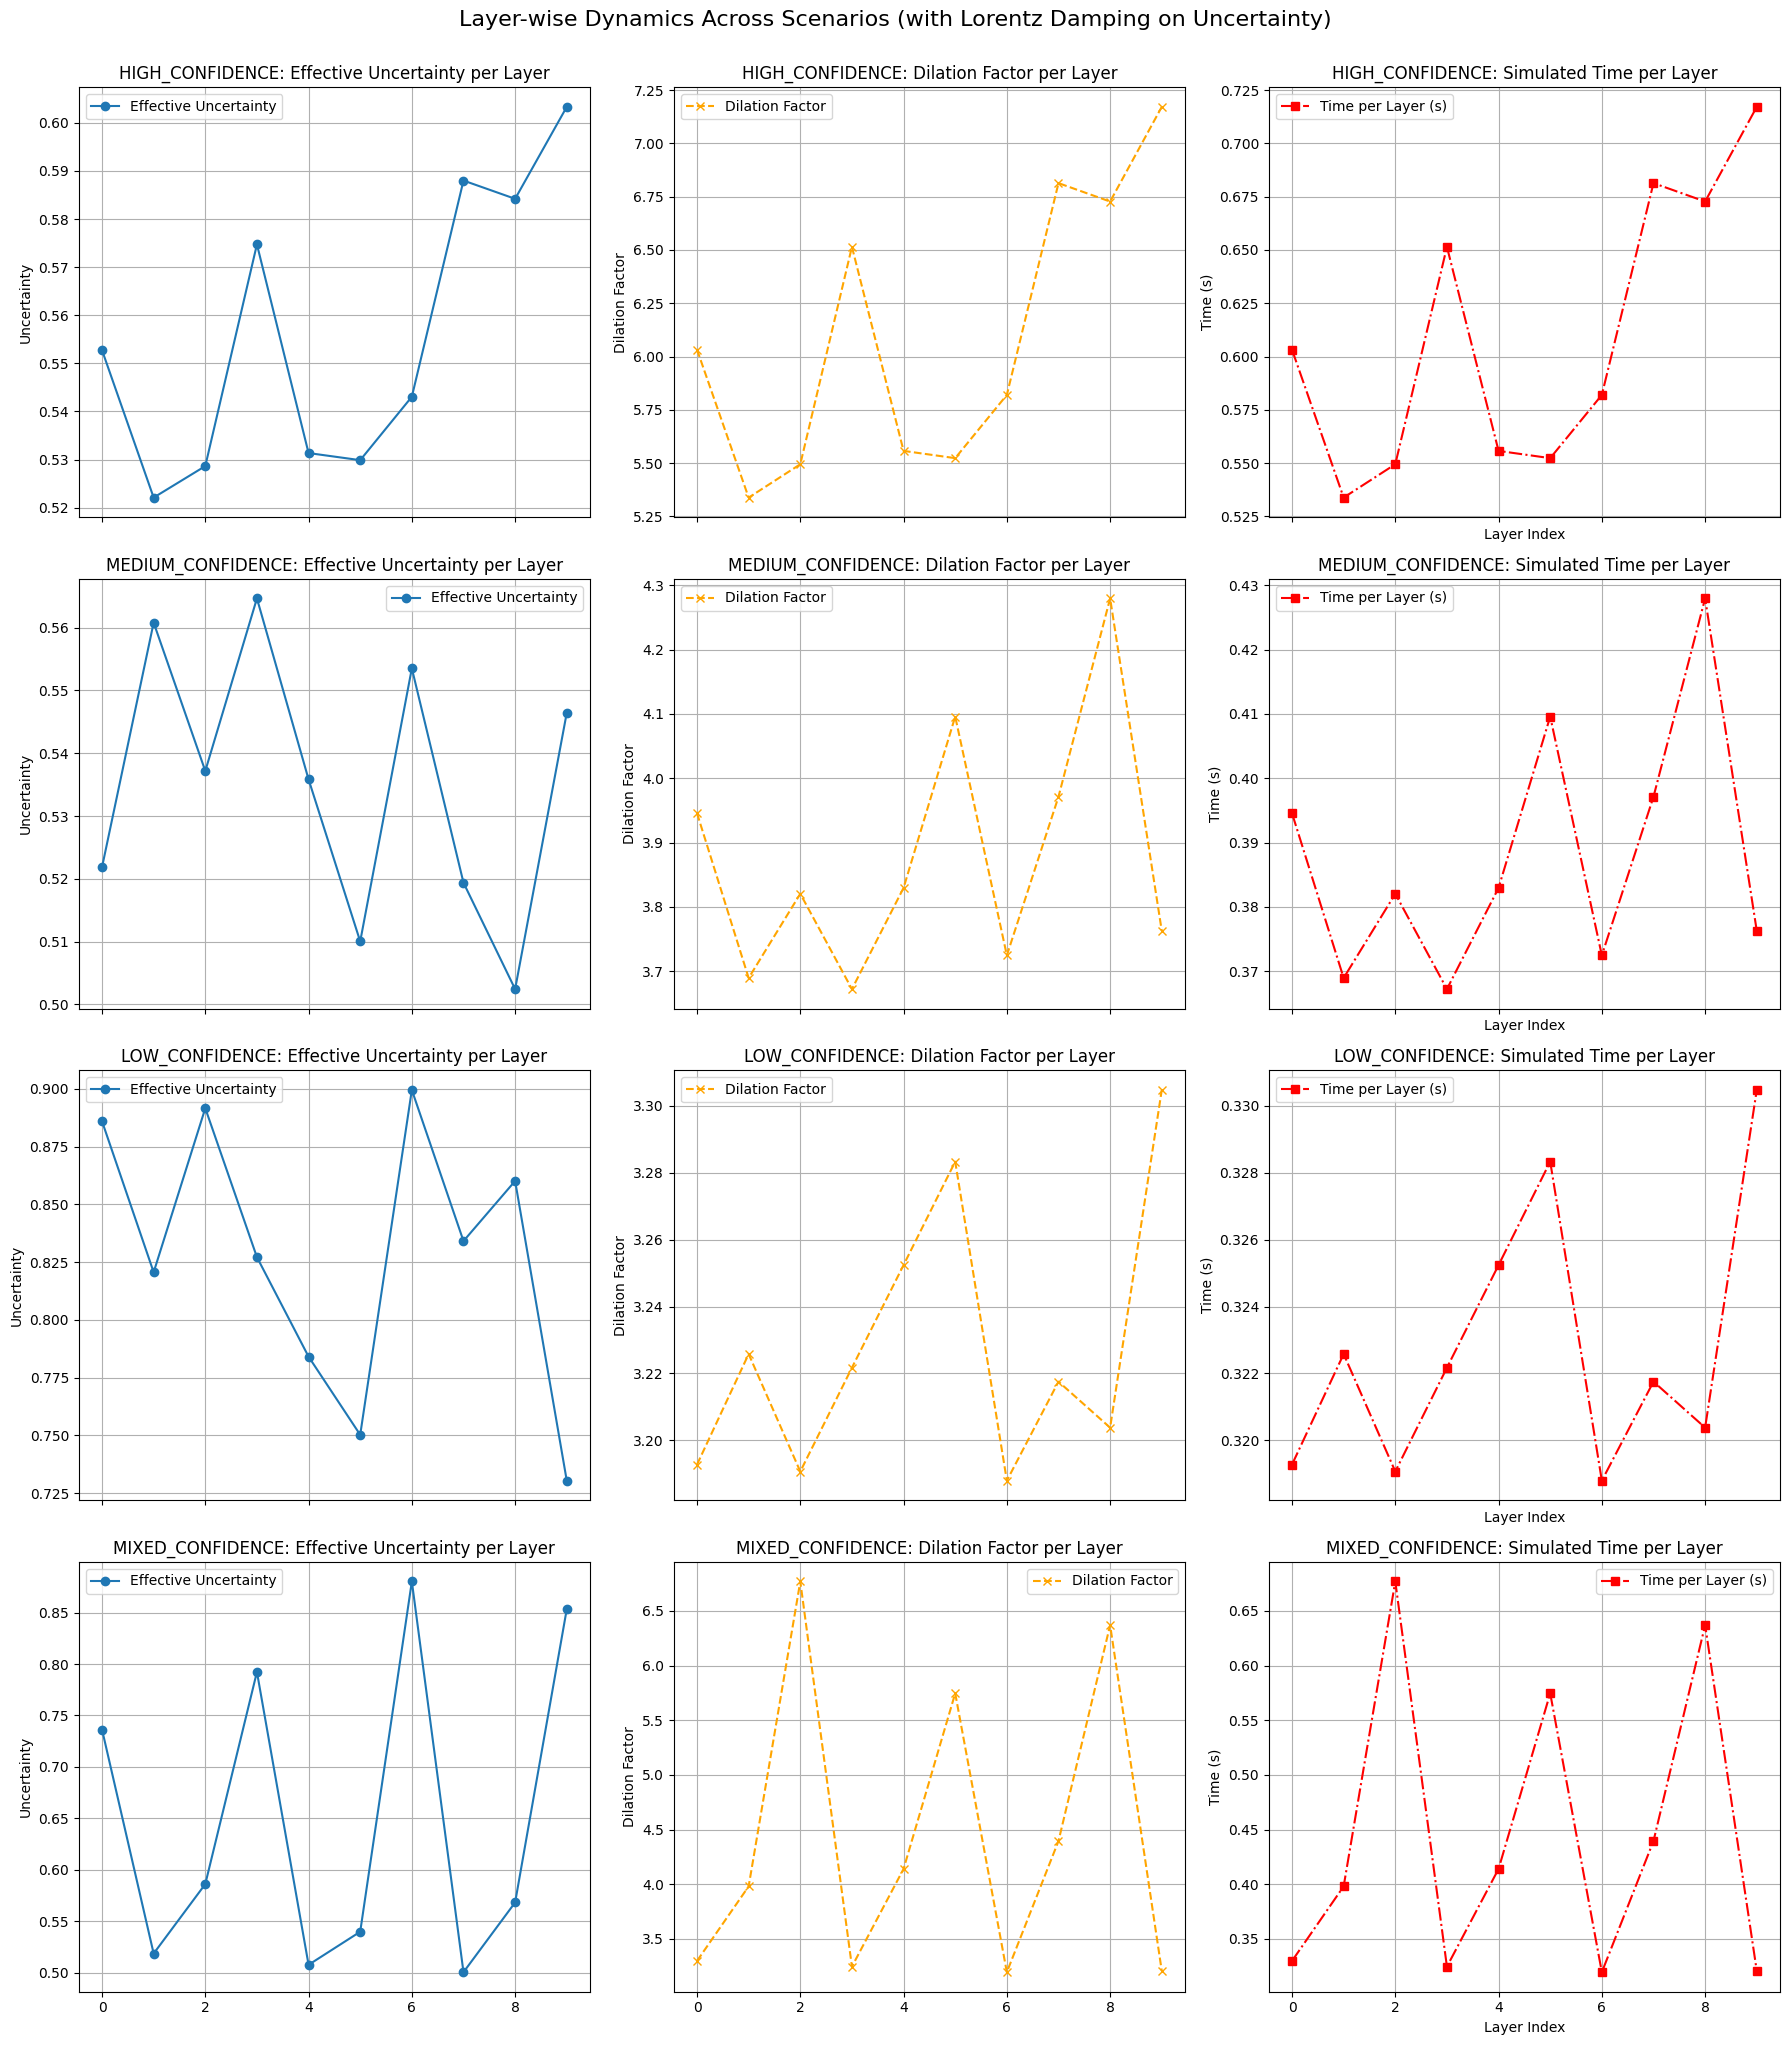

/tmp/ipython-input-1-1567385375.py:224: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_combined[1].set_xticklabels(scenarios, rotation=45, ha="right")
/tmp/ipython-input-1-1567385375.py:231: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_combined[2].set_xticklabels(scenarios, rotation=45, ha="right")


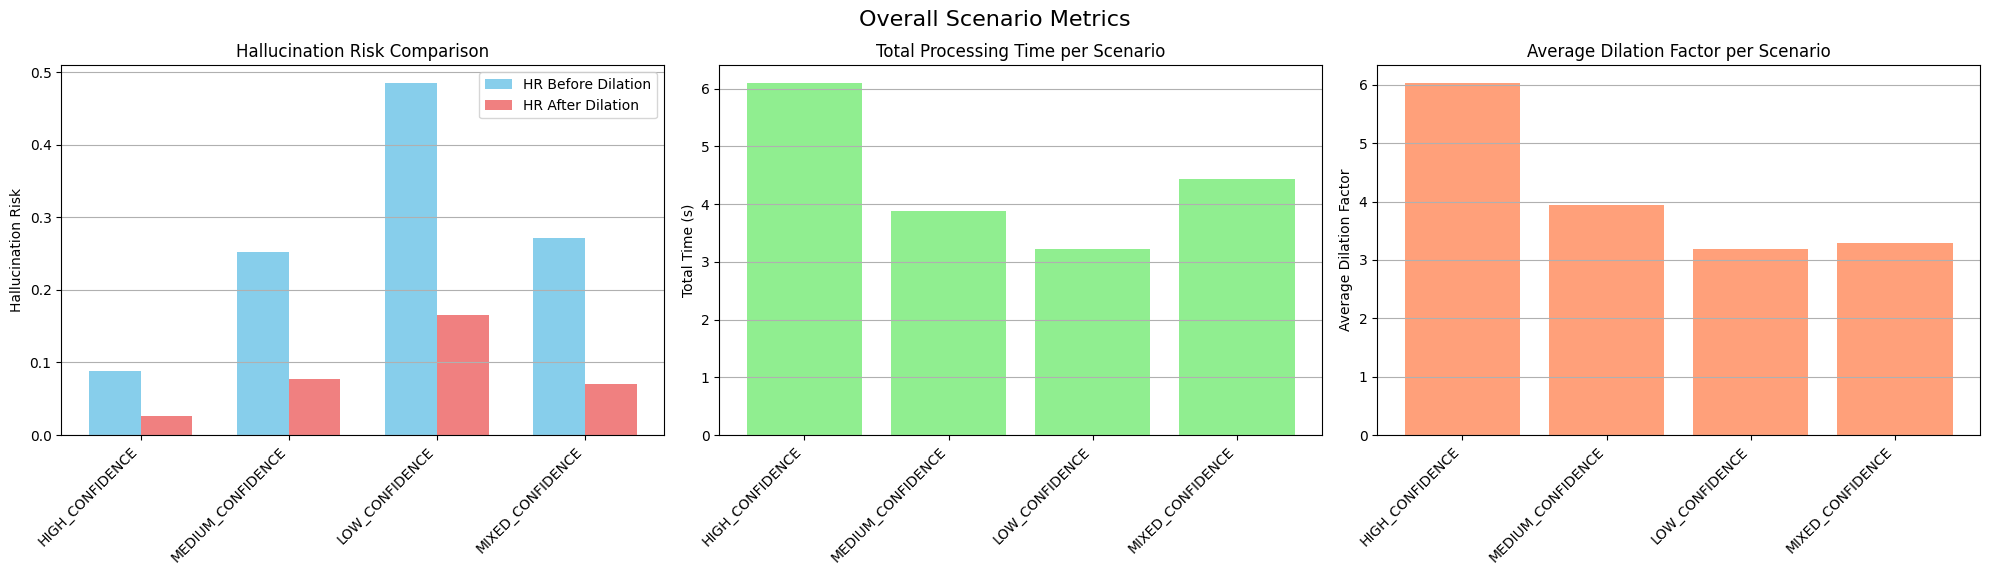


Overall results plot saved as 'poc_visuals.png'

Generating analysis report...
TIME DILATION FOR LLM HALLUCINATION PREVENTION
Proof of Concept Demonstration Report

Learned Optimal Dilation Scaling Factor: 3.172

Scenario             Total Time (s)  Avg. Uncert.    Avg. Dilation   HR Before Dilation   HR After Dilation    HR Reduction (%)    
HIGH_CONFIDENCE      6.099           0.556           6.099           0.089                0.026                70.30               
MEDIUM_CONFIDENCE    3.879           0.535           3.879           0.252                0.077                69.48               
LOW_CONFIDENCE       3.228           0.828           3.228           0.485                0.165                65.99               
MIXED_CONFIDENCE     4.435           0.648           4.435           0.271                0.071                73.96               


Results saved to 'time_dilation_results.json'
DEMONSTRATION COMPLETE


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import math

class LLMTimeDilationPOC:
    def __init__(self, num_layers=10, token_per_layer=100, max_base_time_per_token=0.001,
                 semantic_speed_limit=1.0, learning_rate=0.05, optimization_steps=100):
        self.num_layers = num_layers
        self.token_per_layer = token_per_layer
        self.max_base_time_per_token = max_base_time_per_token
        self.semantic_speed_limit = semantic_speed_limit
        self.learned_dilation_scaling_factor = 1.0 # Initial factor, will be optimized
        self.learning_rate = learning_rate
        self.optimization_steps = optimization_steps

    def _calculate_semantic_velocity(self, uncertainty):
        # Semantic velocity is higher when uncertainty is lower (more confident, faster processing)
        # It's clamped to be less than semantic_speed_limit to avoid mathematical issues
        return self.semantic_speed_limit * (1.0 - uncertainty)

    def _calculate_dilation_factor(self, semantic_velocity):
        # Dilation is higher when semantic velocity is higher (as it approaches speed limit)
        # We ensure velocity does not exceed the limit to prevent complex numbers
        clamped_velocity = min(semantic_velocity, self.semantic_speed_limit * 0.9999) # Avoid division by zero/imaginary numbers
        return 1.0 / math.sqrt(1 - (clamped_velocity / self.semantic_speed_limit)**2)

    def _simulate_layer_processing(self, layer_idx, scenario_type):
        # Simulate base uncertainty for the layer
        if scenario_type == 'HIGH_CONFIDENCE':
            base_uncertainty = np.random.uniform(0.1, 0.2)
        elif scenario_type == 'MEDIUM_CONFIDENCE':
            base_uncertainty = np.random.uniform(0.3, 0.5)
        elif scenario_type == 'LOW_CONFIDENCE':
            base_uncertainty = np.random.uniform(0.7, 0.9)
        elif scenario_type == 'MIXED_CONFIDENCE':
            if layer_idx % 3 == 0:
                base_uncertainty = np.random.uniform(0.7, 0.9)
            elif layer_idx % 3 == 1:
                base_uncertainty = np.random.uniform(0.3, 0.5)
            else:
                base_uncertainty = np.random.uniform(0.1, 0.2)
        else:
            base_uncertainty = np.random.uniform(0.01, 0.99)

        # Calculate semantic velocity based on base_uncertainty
        semantic_velocity = self._calculate_semantic_velocity(base_uncertainty)

        # Calculate raw dilation factor (Lorentz-inspired)
        raw_dilation_factor = self._calculate_dilation_factor(semantic_velocity)

        # Apply learned scaling factor to get effective dilation for time calculation
        effective_dilation_factor = raw_dilation_factor * self.learned_dilation_scaling_factor

        damping_term = raw_dilation_factor if raw_dilation_factor > 1e-6 else 1e-6

        conceptual_confidence = (1.0 - base_uncertainty)
        damped_conceptual_confidence = conceptual_confidence / damping_term

        # Ensure confidence and uncertainty remain within valid bounds (0 to 1)
        damped_conceptual_confidence = max(0.0, min(1.0, damped_conceptual_confidence))
        effective_uncertainty = 1.0 - damped_conceptual_confidence
        effective_uncertainty = max(0.0, min(1.0, effective_uncertainty))

        # Simulated time taken per layer (higher dilation -> more time)
        time_taken = self.max_base_time_per_token * self.token_per_layer * effective_dilation_factor

        return {
            'uncertainty': effective_uncertainty, # Use effective_uncertainty for results
            'semantic_velocity': semantic_velocity,
            'dilation_factor': effective_dilation_factor,
            'time_taken': time_taken,
            'base_uncertainty': base_uncertainty # Keep base for analysis if needed
        }

    def optimize_dilation_factor(self, target_scenario='LOW_CONFIDENCE'):
        print(f"Optimizing dilation scaling factor for '{target_scenario}' scenario...")
        best_risk = float('inf')
        best_factor = self.learned_dilation_scaling_factor
        initial_factor = self.learned_dilation_scaling_factor

        for step in range(self.optimization_steps):
            temp_factor = initial_factor + (np.random.rand() - 0.5) * self.learning_rate * 5
            if temp_factor < 0.1: temp_factor = 0.1
            self.learned_dilation_scaling_factor = temp_factor

            scenario_results = self._run_single_scenario(target_scenario)
            current_risk = scenario_results['hallucination_risk']['after_dilation']

            if current_risk < best_risk:
                best_risk = current_risk
                best_factor = temp_factor

            # Simple update rule: if current factor is better, try nudging in that direction
            if current_risk < self._run_single_scenario(target_scenario, temp_factor_override=initial_factor)['hallucination_risk']['after_dilation']:
                initial_factor = temp_factor
            else:
                initial_factor = best_factor

        self.learned_dilation_scaling_factor = best_factor
        print(f"Optimization complete. Optimal dilation scaling factor: {self.learned_dilation_scaling_factor:.3f}")

    def _run_single_scenario(self, scenario_type, temp_factor_override=None):
        layer_uncertainties = []
        layer_semantic_velocities = []
        layer_dilation_factors = []
        layer_times = []

        original_factor = self.learned_dilation_scaling_factor
        if temp_factor_override is not None:
            self.learned_dilation_scaling_factor = temp_factor_override

        for i in range(self.num_layers):
            results = self._simulate_layer_processing(i, scenario_type)
            layer_uncertainties.append(results['uncertainty'])
            layer_semantic_velocities.append(results['semantic_velocity'])
            layer_dilation_factors.append(results['dilation_factor'])
            layer_times.append(results['time_taken'])

        total_time = sum(layer_times)
        avg_uncertainty = np.mean(layer_uncertainties)
        avg_dilation_factor = np.mean(layer_dilation_factors)

        hallucination_risk_before_dilation = np.mean([
            u * math.exp(-1.0 / 2.0)
            for u in [self._simulate_layer_processing(i, scenario_type)['base_uncertainty'] for i in range(self.num_layers)]
        ])

        hallucination_risk_after_dilation = avg_uncertainty * math.exp(-avg_dilation_factor / 2.0)

        hallucination_risk_before_dilation = max(0.0, min(1.0, hallucination_risk_before_dilation))
        hallucination_risk_after_dilation = max(0.0, min(1.0, hallucination_risk_after_dilation))

        reduction_percentage = ((hallucination_risk_before_dilation - hallucination_risk_after_dilation) / hallucination_risk_before_dilation) * 100 if hallucination_risk_before_dilation > 0 else 0

        self.learned_dilation_scaling_factor = original_factor

        return {
            'token_times': layer_times,
            'uncertainties': layer_uncertainties,
            'semantic_velocities': layer_semantic_velocities,
            'dilation_factors': layer_dilation_factors,
            'total_time': total_time,
            'hallucination_risk': {
                'before_dilation': hallucination_risk_before_dilation,
                'after_dilation': hallucination_risk_after_dilation,
                'reduction_percentage': reduction_percentage
            }
        }

    def run_demonstration(self):
        scenarios = ['HIGH_CONFIDENCE', 'MEDIUM_CONFIDENCE', 'LOW_CONFIDENCE', 'MIXED_CONFIDENCE']
        results = {}

        self.optimize_dilation_factor(target_scenario='LOW_CONFIDENCE')

        for scenario in scenarios:
            print(f"\n--- Running Scenario: {scenario} ---")
            results[scenario] = self._run_single_scenario(scenario)

        return results

    def visualize_results(self, results):
        scenarios = list(results.keys())
        fig, axes = plt.subplots(len(scenarios), 3, figsize=(18, 5 * len(scenarios)), sharex=True)

        if len(scenarios) == 1:
            axes = [axes]

        for i, scenario in enumerate(scenarios):
            scenario_data = results[scenario]

            axes[i][0].plot(scenario_data['uncertainties'], label='Effective Uncertainty', marker='o', linestyle='-')
            axes[i][0].set_title(f'{scenario}: Effective Uncertainty per Layer')
            axes[i][0].set_ylabel('Uncertainty')
            axes[i][0].legend()
            axes[i][0].grid(True)

            axes[i][1].plot(scenario_data['dilation_factors'], label='Dilation Factor', color='orange', marker='x', linestyle='--')
            axes[i][1].set_title(f'{scenario}: Dilation Factor per Layer')
            axes[i][1].set_ylabel('Dilation Factor')
            axes[i][1].legend()
            axes[i][1].grid(True)

            axes[i][2].plot(scenario_data['token_times'], label='Time per Layer (s)', color='red', marker='s', linestyle='-.')
            axes[i][2].set_title(f'{scenario}: Simulated Time per Layer')
            axes[i][2].set_ylabel('Time (s)')
            axes[i][2].set_xlabel('Layer Index')
            axes[i][2].legend()
            axes[i][2].grid(True)

        plt.tight_layout()
        plt.suptitle('Layer-wise Dynamics Across Scenarios (with Lorentz Damping on Uncertainty)', y=1.02, fontsize=16)
        plt.show()

        fig_combined, ax_combined = plt.subplots(1, 3, figsize=(20, 6))

        hr_before = [results[s]['hallucination_risk']['before_dilation'] for s in scenarios]
        hr_after = [results[s]['hallucination_risk']['after_dilation'] for s in scenarios]

        x = np.arange(len(scenarios))
        width = 0.35

        ax_combined[0].bar(x - width/2, hr_before, width, label='HR Before Dilation', color='skyblue')
        ax_combined[0].bar(x + width/2, hr_after, width, label='HR After Dilation', color='lightcoral')
        ax_combined[0].set_ylabel('Hallucination Risk')
        ax_combined[0].set_title('Hallucination Risk Comparison')
        ax_combined[0].set_xticks(x)
        ax_combined[0].set_xticklabels(scenarios, rotation=45, ha="right")
        ax_combined[0].legend()
        ax_combined[0].grid(axis='y')

        total_times = [results[s]['total_time'] for s in scenarios]
        ax_combined[1].bar(scenarios, total_times, color='lightgreen')
        ax_combined[1].set_ylabel('Total Time (s)')
        ax_combined[1].set_title('Total Processing Time per Scenario')
        ax_combined[1].set_xticklabels(scenarios, rotation=45, ha="right")
        ax_combined[1].grid(axis='y')

        avg_dilation_factors = [results[s]['dilation_factors'][0] for s in scenarios]
        ax_combined[2].bar(scenarios, avg_dilation_factors, color='lightsalmon')
        ax_combined[2].set_ylabel('Average Dilation Factor')
        ax_combined[2].set_title('Average Dilation Factor per Scenario')
        ax_combined[2].set_xticklabels(scenarios, rotation=45, ha="right")
        ax_combined[2].grid(axis='y')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.suptitle('Overall Scenario Metrics', y=0.98, fontsize=16)
        plt.show()

        fig_combined.savefig('poc_visuals.png', bbox_inches='tight')
        print("\nOverall results plot saved as 'poc_visuals.png'")

    def generate_report(self, results):
        report = "============================================================\n"
        report += "TIME DILATION FOR LLM HALLUCINATION PREVENTION\n"
        report += "Proof of Concept Demonstration Report\n"
        report += "============================================================\n\n"
        report += f"Learned Optimal Dilation Scaling Factor: {self.learned_dilation_scaling_factor:.3f}\n\n"

        report += "{:<20} {:<15} {:<15} {:<15} {:<20} {:<20} {:<20}\n".format(
            "Scenario", "Total Time (s)", "Avg. Uncert.", "Avg. Dilation",
            "HR Before Dilation", "HR After Dilation", "HR Reduction (%)"
        )
        report += "=" * 125 + "\n"

        for scenario, metrics in results.items():
            report += "{:<20} {:<15.3f} {:<15.3f} {:<15.3f} {:<20.3f} {:<20.3f} {:<20.2f}\n".format(
                scenario,
                metrics['total_time'],
                np.mean(metrics['uncertainties']),
                np.mean(metrics['dilation_factors']),
                metrics['hallucination_risk']['before_dilation'],
                metrics['hallucination_risk']['after_dilation'],
                metrics['hallucination_risk']['reduction_percentage']
            )
        report += "=" * 125 + "\n"
        return report

if __name__ == "__main__":
    print("Initializing Time Dilation POC...")
    poc = LLMTimeDilationPOC()

    print("Running demonstration scenarios...")
    results = poc.run_demonstration()

    print("\nGenerating visualizations...")
    poc.visualize_results(results)

    print("\nGenerating analysis report...")
    report = poc.generate_report(results)
    print(report)

    with open('time_dilation_results.json', 'w') as f:
        serializable_results = {}
        for scenario, metrics in results.items():
            serializable_results[scenario] = {
                'token_times': metrics['token_times'],
                'uncertainties': metrics['uncertainties'],
                'semantic_velocities': metrics['semantic_velocities'],
                'dilation_factors': metrics['dilation_factors'],
                'total_time': metrics['total_time'],
                'hallucination_risk': metrics['hallucination_risk']
            }
        json.dump(serializable_results, f, indent=2)

    print("\nResults saved to 'time_dilation_results.json'")
    print("=" * 60)
    print("DEMONSTRATION COMPLETE")